## Домашнее задание : "Обучение с подкреплением"

ФИО: Филимонов Степан Владиславович

In [1]:
!pip install gymnasium pygame seaborn pandas numpy matplotlib tqdm Box2D

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 46.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 72.8 MB/s eta 0:00:00


In [2]:
from pathlib import Path
from typing import NamedTuple
from __future__ import annotations
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

sns.set_theme()

# Задание 1

Обучите алгоритм Q-learning для сред FrozenLake-v1 и Blackjack-v1, в частности подберите оптимальную alpha. (2 балла)

## FrozenLake-v1

In [3]:
class Params(NamedTuple):
    total_episodes: int
    learning_rate : float 
    gamma         : float
    epsilon       : float
    map_size      : int
    seed          : int
    is_slippery   : bool   # Если значение равно true, игрок будет двигаться в заданном направлении
                           # с вероятностью 1/3, остальные будут двигаться в любом перпендикулярном
                           # направлении с равной вероятностью 1/3 в обоих направлениях.
    n_runs        : int
    action_size   : int
    state_size    : int
    proba_frozen  : float

In [4]:
params = Params(
    total_episodes=3000,
    learning_rate=0.5,
    gamma=0.95,
    epsilon=0.1,
    map_size=5,
    seed=111,
    is_slippery=False,
    n_runs=20,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
)
params

Params(total_episodes=3000, learning_rate=0.5, gamma=0.95, epsilon=0.1, map_size=5, seed=111, is_slippery=False, n_runs=20, action_size=None, state_size=None, proba_frozen=0.9)

In [5]:
rng = np.random.default_rng(params.seed)

In [6]:
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=params.map_size,
        p=params.proba_frozen,
        seed=params.seed
    ),
)

In [7]:
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
print(f"Action size: {params.action_size}")
print(f"State size: {params.state_size}")

Action size: 4
State size: 25


In [8]:
class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def update(self, state, action, reward, new_state):
        delta = (reward + self.gamma * np.max(self.qtable[new_state, :]) - self.qtable[state, action])
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    def reset_qtable(self):
        self.qtable = np.zeros((self.state_size, self.action_size))

In [9]:
class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def choose_action(self, action_space, state, qtable):
        explor_exploit_tradeoff = rng.uniform(0, 1)

        if explor_exploit_tradeoff < self.epsilon:
            action = action_space.sample()
        else:
            max_ids = np.where(qtable[state, :] == max(qtable[state, :]))[0]
            action = rng.choice(max_ids)
        return action

In [10]:
learner = Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    state_size=params.state_size,
    action_size=params.action_size,
)

In [11]:
explorer = EpsilonGreedy(epsilon=params.epsilon,)

In [12]:
def run_env():
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []

    for run in range(params.n_runs):
        learner.reset_qtable()

        for episode in tqdm(episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False):
            state = env.reset(seed=params.seed)[0]
            step = 0
            done = False
            total_rewards = 0

            while not done:
                action = explorer.choose_action(action_space=env.action_space, state=state, qtable=learner.qtable)

                all_states.append(state)
                all_actions.append(action)

                new_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated

                learner.qtable[state, action] = learner.update(state, action, reward, new_state)

                total_rewards += reward
                step += 1

                state = new_state

            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = learner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions

In [13]:
def postprocess(episodes, params, rewards, steps, map_size):
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params.n_runs),
            "Rewards": rewards.flatten(order="F"),
            "Steps": steps.flatten(order="F"),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])

    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    return res, st

In [14]:
def qtable_directions_map(qtable, map_size):
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

In [15]:
def plot_q_values_map(qtable, env, map_size):
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Последний график
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # тепловая карта шагов
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")

    plt.show()

In [16]:
def plot_states_actions_distribution(states, actions, map_size):
    labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    sns.histplot(data=states, ax=ax[0], kde=True)
    ax[0].set_title("States")

    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title("Actions")
    fig.tight_layout()
    plt.show()

In [17]:
def plot_steps_and_rewards(rewards_df, steps_df):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(data=rewards_df, x="Episodes", y="cum_rewards", hue="map_size", ax=ax[0])
    ax[0].set(ylabel="Cumulated rewards")

    sns.lineplot(data=steps_df, x="Episodes", y="Steps", hue="map_size", ax=ax[1])
    ax[1].set(ylabel="Averaged steps number")

    _ = [axi.legend(title="map size") for axi in ax ]
    fig.tight_layout()
    plt.show()

Map size: 5x5


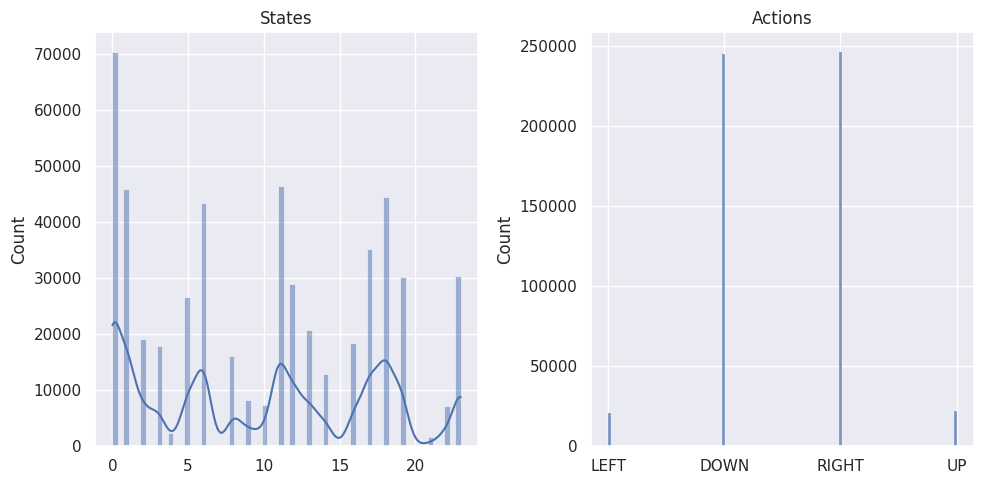

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


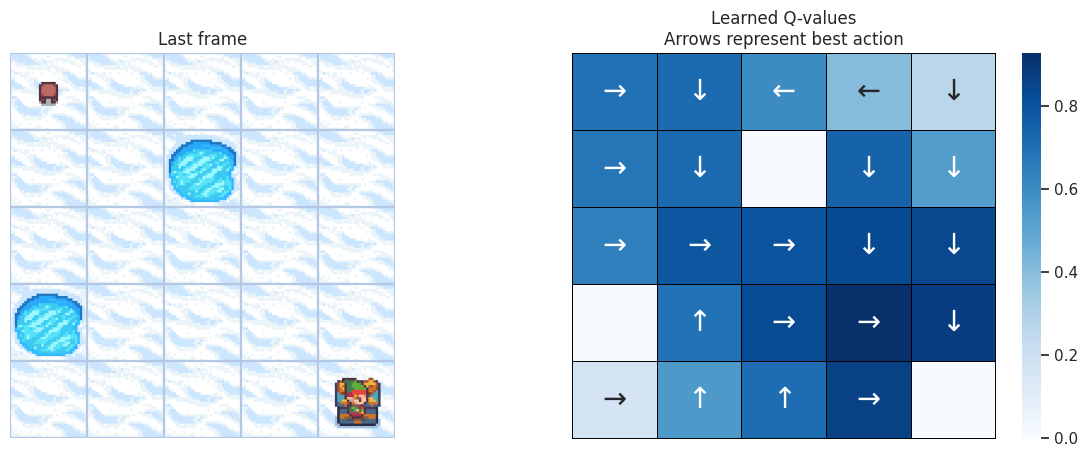

Map size: 10x10


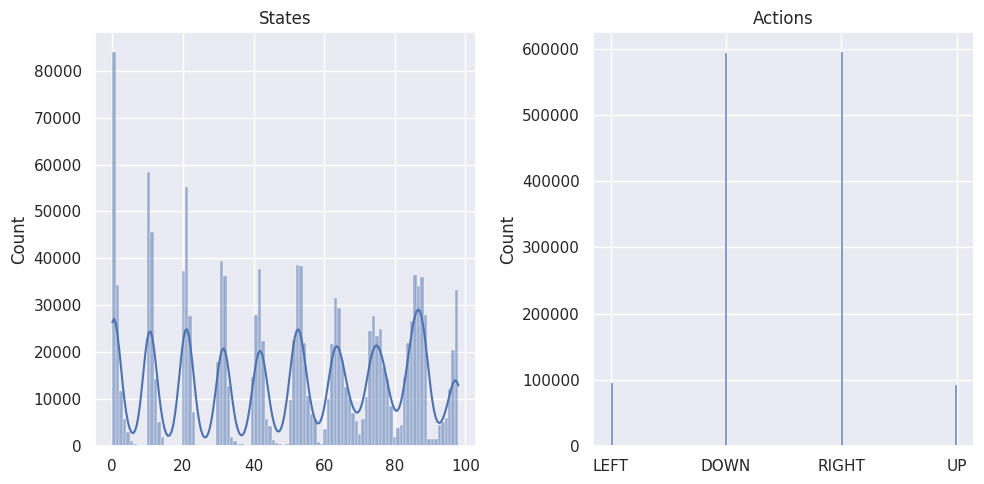

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


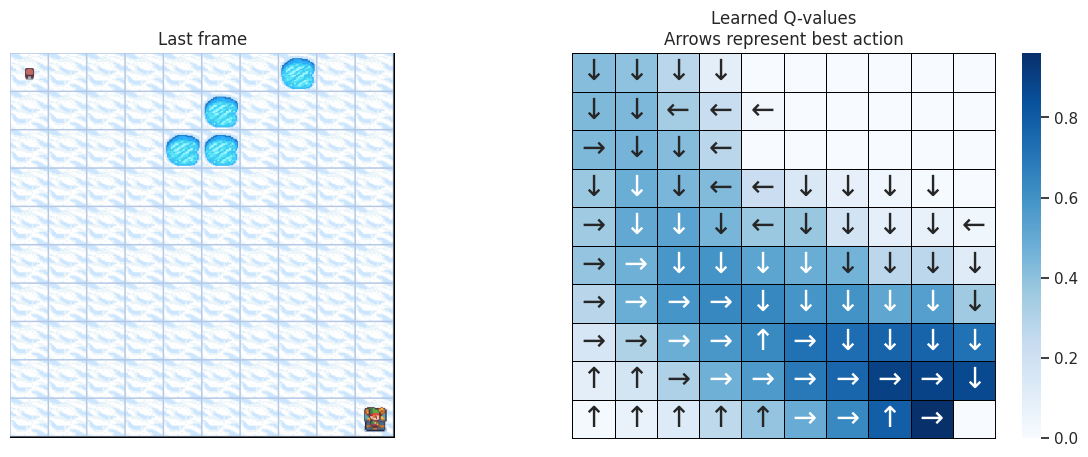

Map size: 15x15


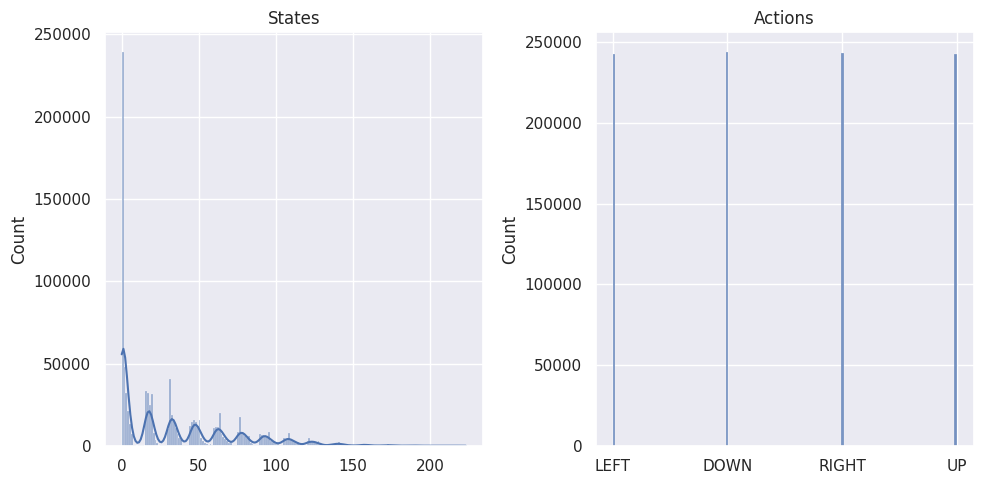

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


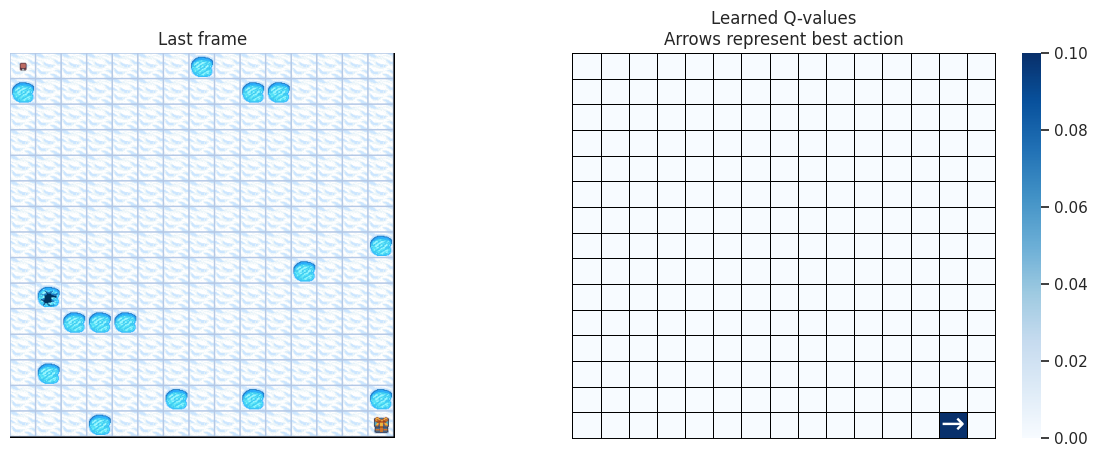

Map size: 20x20


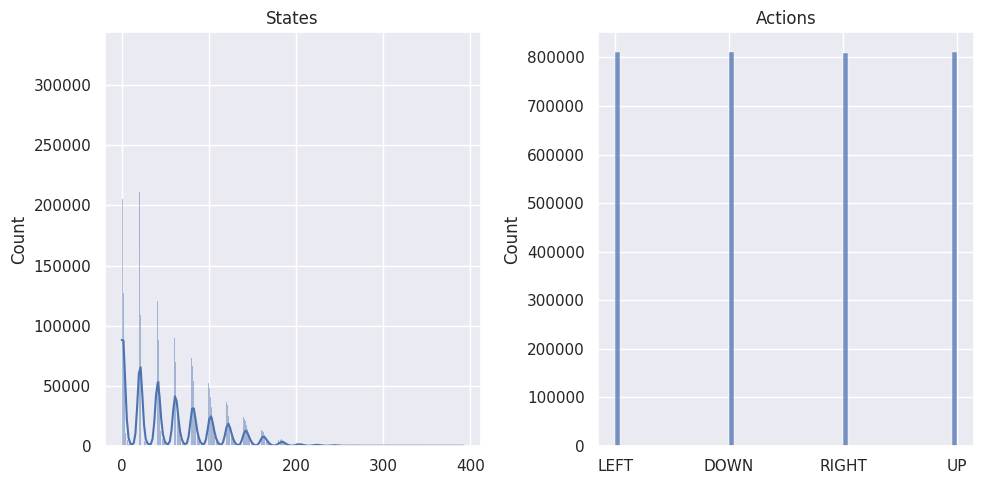

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


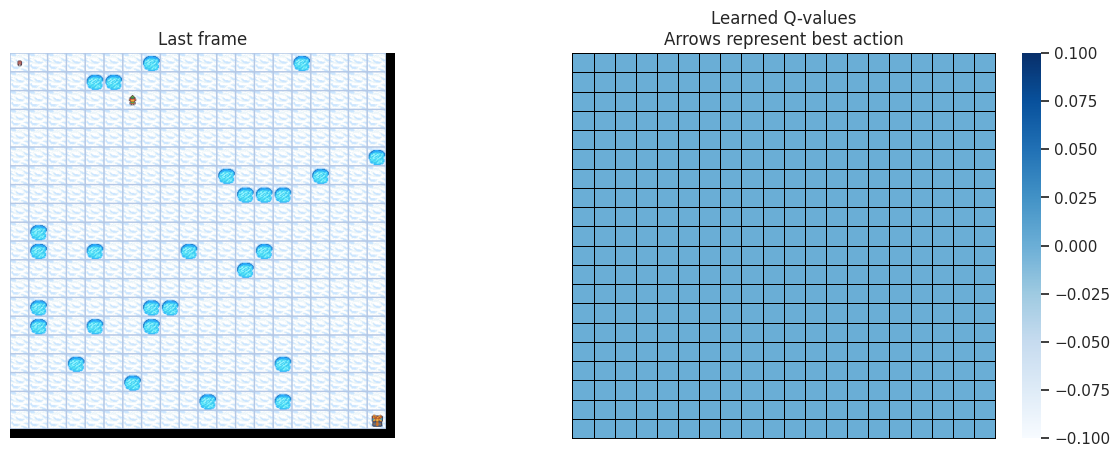

In [18]:
map_sizes = [5, 10, 15, 20]
res_all = pd.DataFrame()
st_all = pd.DataFrame()

for map_size in map_sizes:
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=params.is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=params.proba_frozen, seed=params.seed
        ),
    )

    params = params._replace(action_size=env.action_space.n)
    params = params._replace(state_size=env.observation_space.n)
    # Установка начального значения, чтобы получить воспроизводимые
    # результаты при выборке пространства действия
    env.action_space.seed(params.seed)
    learner = Qlearning(
        learning_rate=params.learning_rate,
        gamma=params.gamma,
        state_size=params.state_size,
        action_size=params.action_size,
    )
    explorer = EpsilonGreedy(
        epsilon=params.epsilon,
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = run_env()

    # Сохранение данных
    res, st = postprocess(episodes, params, rewards, steps, map_size)
    res_all = pd.concat([res_all, res])
    st_all = pd.concat([st_all, st])
    qtable = qtables.mean(axis=0)

    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size
    )
    plot_q_values_map(qtable, env, map_size)

    env.close()

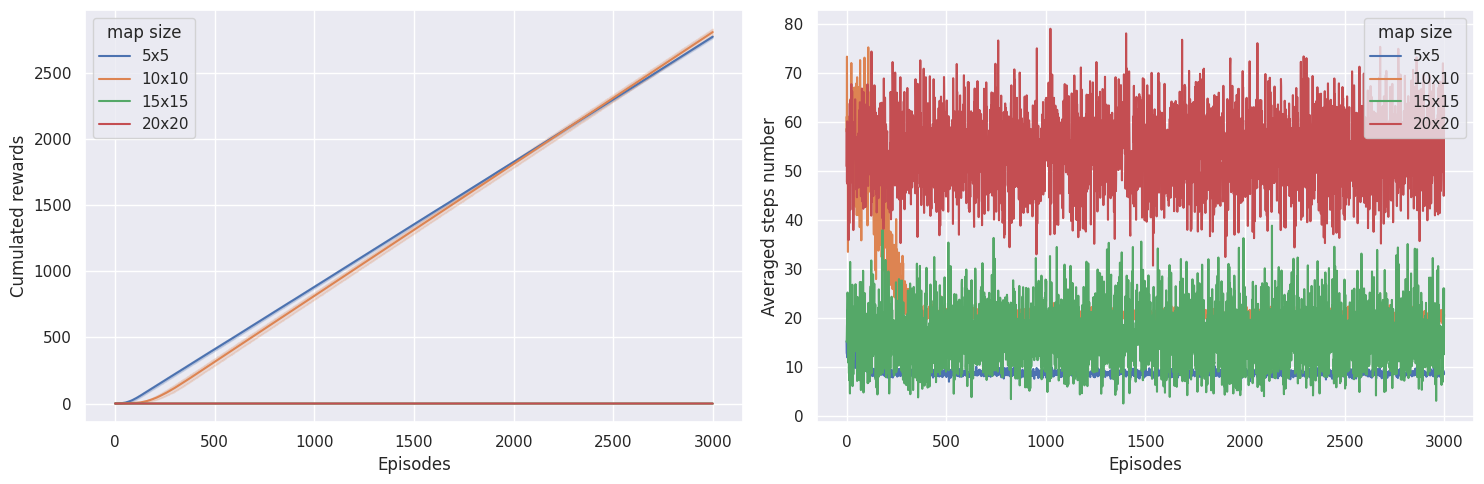

In [19]:
plot_steps_and_rewards(res_all, st_all)

**Промежуточный вывод:**

0) Запустил для FrozenLake-v1 обучение из примера

1) На больших картах не хватает шагов для выполнения

## Blackjack-v1

In [20]:
env = gym.make("Blackjack-v1", sab=True)

In [21]:
done = False
observation, info = env.reset()
observation

(13, 9, 0)

In [22]:
action = env.action_space.sample()
action

np.int64(0)

In [23]:
observation, reward, terminated, truncated, info = env.step(action)

In [24]:
observation

(13, 9, 0)

In [25]:
reward

-1.0

In [26]:
terminated

True

In [27]:
truncated

False

In [28]:
info

{}

In [29]:
class BlackjackAgent:
    def __init__(
        self,
        env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, env, obs: tuple[int, int, bool]) -> int:
        return env.action_space.sample() if np.random.random() < self.epsilon else int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (reward + self.discount_factor * future_q_value - self.q_values[obs][action])

        self.q_values[obs][action] = (self.q_values[obs][action] + self.lr * temporal_difference)
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [30]:
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [31]:
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(env, obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        agent.update(obs, action, reward, terminated, next_obs)

        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 13968.85it/s]


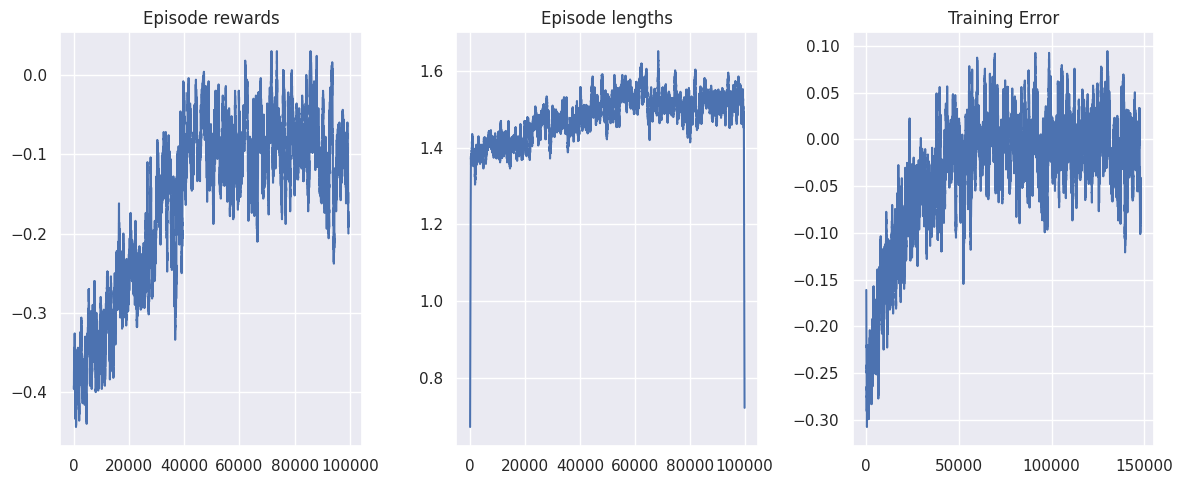

In [32]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")

reward_moving_average = (
    np.convolve(np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid") / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same") / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same") / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

In [33]:
def create_grids(agent, usable_ace=False):
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(np.arange(12, 22), np.arange(1, 11),)

    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid

In [34]:
def create_plots(value_grid, policy_grid, title: str):
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig

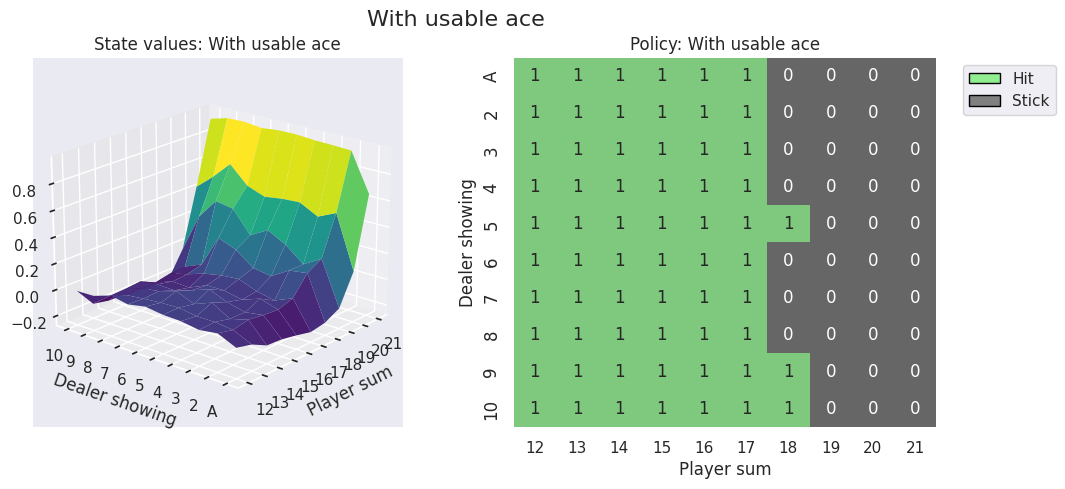

In [35]:
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

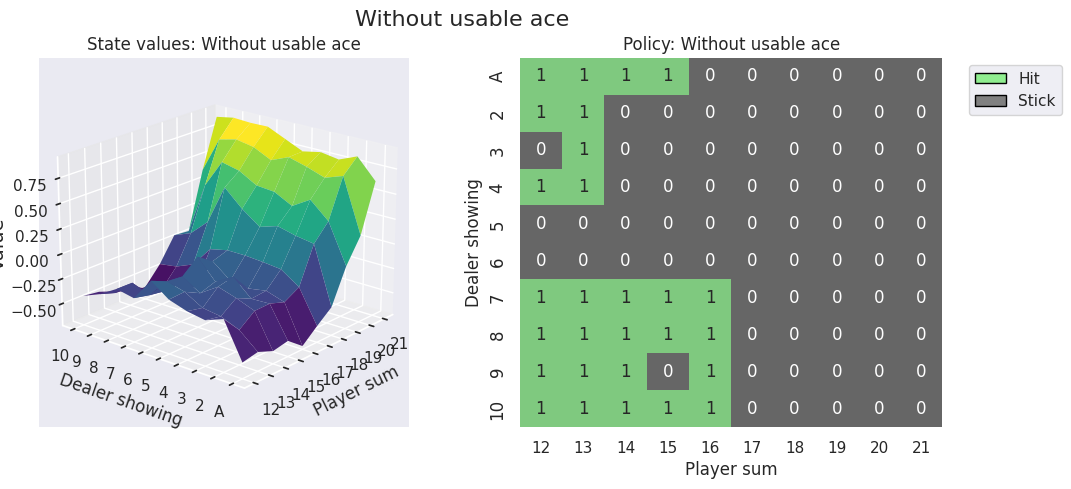

In [36]:
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

**Промежуточный вывод:**

0) Запустил из примера

# Задание 2

Обучите алгоритм Policy Gradients (или Actor Critic) для среды https://www.gymlibrary.dev/environments/atari/breakout/ . Продемонстрируйте, что для обученного агента растет время игры. (3 балла)

Не успевал